# Load Data and Pakcages

In [120]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [121]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Simple RNN

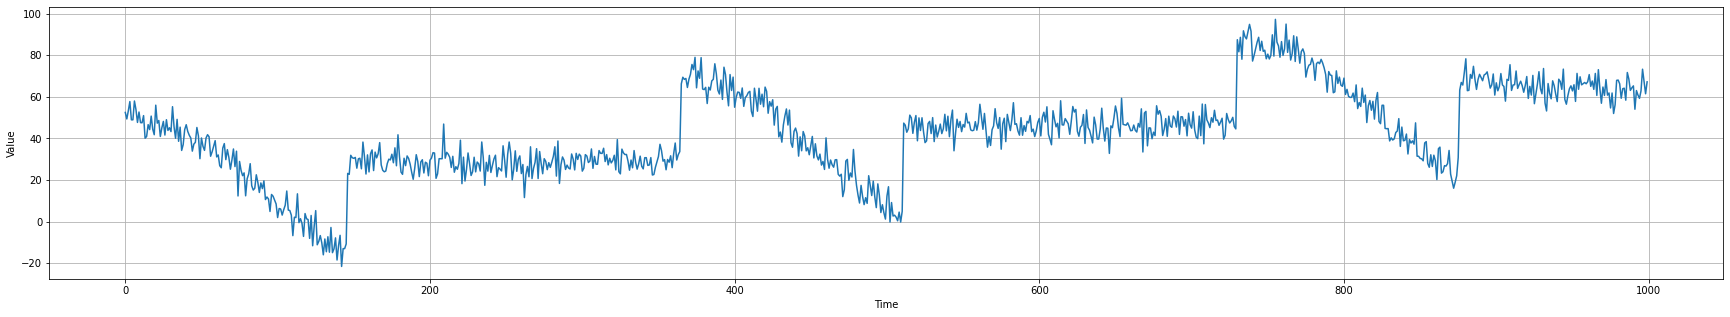

In [122]:
plt.figure(figsize=(30,5))
plot_series(time_train, x_train)

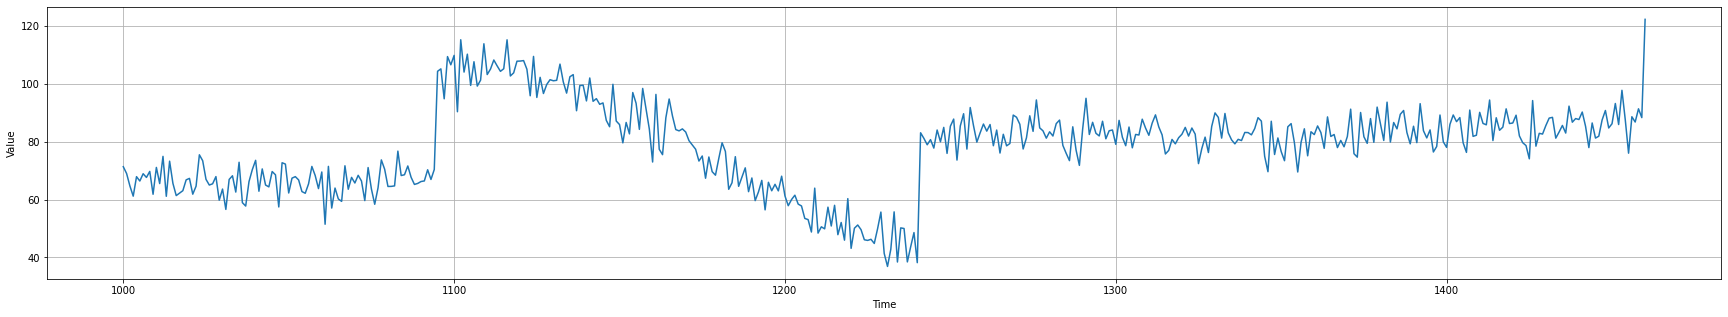

In [123]:
plt.figure(figsize=(30,5))
plot_series(time_valid, x_valid)

In [147]:
series

array([ 52.48357 ,  49.35275 ,  53.314735, ...,  91.37325 ,  88.32383 ,
       122.30772 ], dtype=float32)

In [ ]:
# data = tf.keras.utils.normalize(series)
tensor_data = tf.data.Dataset.from_tensor_slices(series)
tensor_data = tensor_data.window(size=window_size+1, shift=window_shift, stride=window_stride, drop_remainder=True)

for data in tensor_data:
  print(data.as_numpy_iterator)

In [174]:
def transform_window_data_RNN(series_data, window_size, window_shift, window_stride):
  tensor_data = tf.data.Dataset.from_tensor_slices(series_data)
  tensor_data = tensor_data.window(size=window_size+1, shift=window_shift, stride=window_stride, drop_remainder=True)
  tensor_data = tensor_data.flat_map(lambda window_data: window_data.batch(window_size+1))
  tensor_data = tensor_data.shuffle(series_data.size)
  tensor_data = tensor_data.map(lambda window_data: (window_data[:-1], window_data[-1:]))
  # tensor_data = tensor_data.map(lambda value, label: (tf.expand_dims(value,-1),label))
  tensor_data = tensor_data.prefetch(1)
  return tensor_data

In [175]:
window_size = 20
window_shift = 1
window_stride = 1
batch_size = 128
epoch=50
train_data = transform_window_data_RNN(x_train, window_size, window_shift, window_stride)
test_data = transform_window_data_RNN(x_valid, window_size, window_shift, window_stride)

In [176]:
for data, label in train_data:
  print(data.shape)
  print(label.shape)
  print(data)
  print(label)
  break

(20,)
(1,)
tf.Tensor(
[41.55169  49.94979  41.515324 46.151627 43.403996 48.186077 47.458817
 50.97794  43.240307 44.441578 40.89809  43.571808 47.681534 49.58213
 41.188908 50.1507   52.584183 47.876865 55.197754 41.949287], shape=(20,), dtype=float32)
tf.Tensor([39.599785], shape=(1,), dtype=float32)


In [178]:
"""
- shape=(time_step, feature_size)
- time_step: the number of RNN cells
- feature_size: input feature size per sample
- unit: output feature seize per sample per RNN cell
"""
tf.keras.backend.clear_session()
ipt = tf.keras.Input(shape=(20,1))
opt = tf.keras.layers.SimpleRNN(units=40, return_sequences=True)(ipt)
opt = tf.keras.layers.SimpleRNN(units=40)(opt)
opt = tf.keras.layers.Flatten()(opt)
opt = tf.keras.layers.Dense(1)(opt)
opt = tf.keras.layers.Lambda(lambda x: x * 100.0)(opt)
model = tf.keras.models.Model(ipt, opt)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
flatten (Flatten)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
___________________________________________________________

In [179]:
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_data, epochs=50, validation_data = test_data, batch_size=batch_size)

Epoch 1/50
    966/Unknown - 3s 2ms/step - loss: 38.7817 - mae: 39.2798WARNING:tensorflow:Model was constructed with shape (None, 20, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None, 1, 1).
980/980 [==============================] - 4s 3ms/step - loss: 38.6518 - mae: 39.1498 - val_loss: 27.3702 - val_mae: 27.8695
Epoch 2/50
980/980 [==============================] - 2s 2ms/step - loss: 18.3106 - mae: 18.8035 - val_loss: 35.7629 - val_mae: 36.2618
Epoch 3/50
980/980 [==============================] - 2s 2ms/step - loss: 16.5065 - mae: 17.0002 - val_loss: 34.5969 - val_mae: 35.0962
Epoch 4/50
980/980 [==============================] - 2s 2ms/step - loss: 15.2320 - mae: 15.7271 - val_loss: 33.4596 - val_mae: 33.9587
Epoch 5/50
980/980 [==============================] - 2s 2ms/step - loss: 14.4368 - mae: 14.9295 - val_l

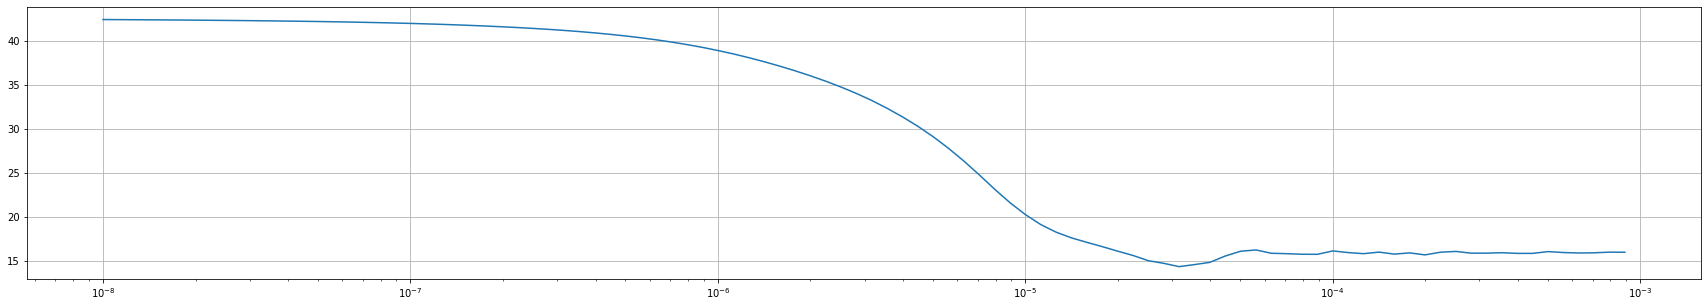

In [ ]:
plt.figure(figsize=(30,5))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.grid()
plt.show()

In [ ]:
tf.keras.backend.clear_session()
ipt = tf.keras.Input(shape=(window_size,1))
opt_1 = tf.keras.layers.SimpleRNN(units=40, activation='tanh', return_sequences=True)(ipt)
opt_2 = tf.keras.layers.SimpleRNN(units=40, activation='tanh', return_sequences=False)(opt_1)
opt_3 = tf.keras.layers.Dense(1)(opt_2)
opt = tf.keras.layers.Lambda(lambda x: x * 100.0)(opt_3)
model_RNN = tf.keras.models.Model(ipt, opt)

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model_RNN.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model_RNN.fit(train_data, validation_data=test_data, epochs=epoch, batch_size=batch_size)

Epoch 1/100
    967/Unknown - 3s 2ms/step - loss: 33.9873 - mae: 34.4827WARNING:tensorflow:Model was constructed with shape (None, 20, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 20, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None, 1, 1).
980/980 [==============================] - 4s 3ms/step - loss: 33.8555 - mae: 34.3508 - val_loss: 32.7361 - val_mae: 33.2332
Epoch 2/100
980/980 [==============================] - 2s 2ms/step - loss: 18.4239 - mae: 18.9211 - val_loss: 27.5626 - val_mae: 28.0608
Epoch 3/100
980/980 [==============================] - 2s 2ms/step - loss: 17.8519 - mae: 18.3498 - val_loss: 26.6415 - val_mae: 27.1405
Epoch 4/100
980/980 [==============================] - 2s 2ms/step - loss: 17.2929 - mae: 17.7867 - val_loss: 25.2954 - val_mae: 25.7953
Epoch 5/100
980/980 [==============================] - 2s 2ms/step - loss: 17.3883 - mae: 17.8809 - 

In [ ]:
model_RNN.predict(test_data)

array([[43.780865],
       [43.780865],
       [43.780865],
       ...,
       [43.780865],
       [43.780865],
       [43.780865]], dtype=float32)

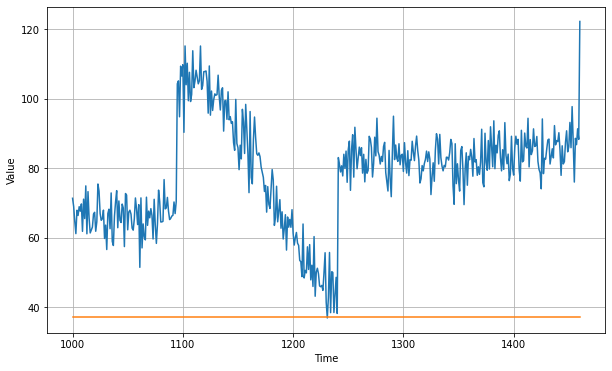

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

41.432484

<Figure size 432x288 with 0 Axes>

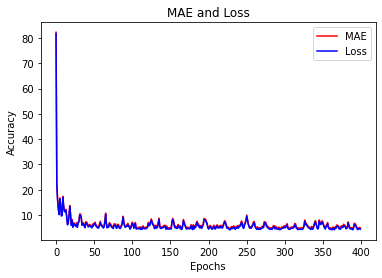

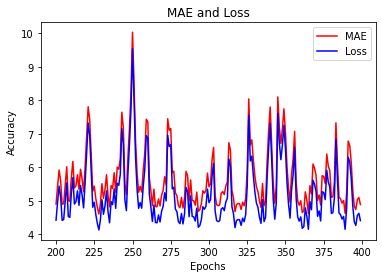

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()